# 05 - 2026 Fantasy Predictions

Generate 2026 fantasy point predictions:

1. **Retrain models** on all data (2016-2025)
2. **Predict rate stats** (Fpoints/PA, Fpoints/IP) for 2026 using 2025 features
3. **Apply external projections** (PA/IP/W/L/SV) to get total fantasy points
4. **Generate final rankings**

In [100]:
import sys
import os

# Set working directory to project root
if 'notebooks' in os.getcwd():
    os.chdir('..')
sys.path.insert(0, os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

from config.settings import PROCESSED_DATA_DIR, MODELS_DIR, RAW_DATA_DIR, RANDOM_STATE
from config.scoring import PITCHER_SCORING_TEAM

import warnings
warnings.filterwarnings('ignore')

np.random.seed(RANDOM_STATE)
print(f"Project root: {os.getcwd()}")

Project root: /Users/matthewgillies/mlb-fantasy-2026


---
## Part 1: Batter Predictions
---

### 1.1 Load Data & Retrain Model

In [101]:
# Load processed batter data
batters = pd.read_csv(f"{PROCESSED_DATA_DIR}/batters_processed.csv")
print(f"Loaded {len(batters)} batter-seasons")
print(f"Years: {batters['Season'].min()} - {batters['Season'].max()}")

# Feature columns (lag features only - these use previous year data to predict current year)
feature_cols_bat = [c for c in batters.columns if '_lag' in c]
print(f"\nFeatures: {len(feature_cols_bat)}")

Loaded 3663 batter-seasons
Years: 2016 - 2025

Features: 50


In [102]:
# Train on ALL data (2016-2025) for final model
# We use all years since we're predicting 2026, not evaluating
train_df_bat = batters.copy()

X_train_bat = train_df_bat[feature_cols_bat].copy()
y_train_bat = train_df_bat['Fpoints_PA'].copy()

# Fill NaN with median
train_medians_bat = X_train_bat.median()
X_train_bat = X_train_bat.fillna(train_medians_bat)

print(f"Training set: {len(X_train_bat)} rows (all years)")
print(f"Features: {X_train_bat.shape[1]}")

Training set: 3663 rows (all years)
Features: 50


In [103]:
# Train Random Forest (best performer from evaluation)
# Using similar params to what worked well in evaluation
rf_bat = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Training batter model on all data...")
rf_bat.fit(X_train_bat, y_train_bat)
print("Done!")

# Store for later use
batter_model = rf_bat

Training batter model on all data...
Done!


### 1.2 Prepare 2026 Prediction Data

For 2026 predictions, we use 2025 stats as `_lag1` features.

In [104]:
# Get 2025 player data to use as features for 2026 predictions
# The 2025 row already has lag1 features (which are 2024 data)
# For 2026, we need 2025 data as lag1

# Get base features from 2025 (these become lag1 for 2026)
batters_2025 = batters[batters['Season'] == 2025].copy()
print(f"Players with 2025 data: {len(batters_2025)}")

# The feature columns we need for 2026 prediction are the _lag1 columns
# But we need to populate them with 2025 current-year values

# Get the base feature names (without _lag1 suffix)
base_features = [c.replace('_lag1', '') for c in feature_cols_bat if '_lag1' in c]
print(f"Base features needed: {len(base_features)}")

Players with 2025 data: 461
Base features needed: 25


In [105]:
# Create 2026 prediction dataframe
# Use 2025 actual values as lag1, and 2025 lag1 as lag2

pred_2026_bat = batters_2025[['IDfg', 'Name', 'Team', 'Age', 'PA', 'Fpoints_PA']].copy()
pred_2026_bat = pred_2026_bat.rename(columns={'Fpoints_PA': 'Fpoints_PA_2025', 'PA': 'PA_2025', 'Age': 'Age_2025'})

# Build feature matrix for 2026 prediction
X_2026_bat = pd.DataFrame(index=batters_2025.index)

for feat in base_features:
    # lag1 for 2026 = current value in 2025
    if feat in batters_2025.columns:
        X_2026_bat[f'{feat}_lag1'] = batters_2025[feat].values
    else:
        X_2026_bat[f'{feat}_lag1'] = np.nan
    
    # lag2 for 2026 = lag1 value in 2025 (which was 2024 data)
    lag1_col = f'{feat}_lag1'
    if lag1_col in batters_2025.columns:
        X_2026_bat[f'{feat}_lag2'] = batters_2025[lag1_col].values
    else:
        X_2026_bat[f'{feat}_lag2'] = np.nan

# Ensure column order matches training
X_2026_bat = X_2026_bat[feature_cols_bat]

# Fill missing with training medians
X_2026_bat = X_2026_bat.fillna(train_medians_bat)

print(f"2026 prediction matrix: {X_2026_bat.shape}")
print(f"NaN count: {X_2026_bat.isna().sum().sum()}")

2026 prediction matrix: (461, 50)
NaN count: 0


### 1.3 Generate Rate Predictions

In [106]:
# Predict Fpoints/PA for 2026
pred_2026_bat['Predicted_Fpoints_PA'] = batter_model.predict(X_2026_bat)

# Sort by predicted rate
pred_2026_bat = pred_2026_bat.sort_values('Predicted_Fpoints_PA', ascending=False).reset_index(drop=True)

print("\n=== 2026 Batter Rate Predictions (Fpoints/PA) ===")
print(f"Players: {len(pred_2026_bat)}")
print(f"\nTop 25 by predicted Fpoints/PA:")
display_cols = ['Name', 'Team', 'Age_2025', 'PA_2025', 'Fpoints_PA_2025', 'Predicted_Fpoints_PA']
print(pred_2026_bat[display_cols].head(25).to_string(index=False))


=== 2026 Batter Rate Predictions (Fpoints/PA) ===
Players: 461

Top 25 by predicted Fpoints/PA:
                 Name  Team  Age_2025  PA_2025  Fpoints_PA_2025  Predicted_Fpoints_PA
          Aaron Judge   NYY        33      679         0.882180              0.776523
            Juan Soto   NYM        26      715         0.777622              0.769011
        Shohei Ohtani   LAD        30      727         0.784044              0.713625
         Jose Ramirez   CLE        32      673         0.775632              0.711536
       Bobby Witt Jr.   KCR        25      687         0.671033              0.688135
          Kyle Tucker   CHC        28      597         0.703518              0.667239
       Yordan Alvarez   HOU        28      199         0.557789              0.653788
         Corey Seager   TEX        31      445         0.606742              0.649672
          Ketel Marte   ARI        31      556         0.705036              0.641363
Vladimir Guerrero Jr.   TOR        26      

### 1.4 SHAP Explainability for 2026 Batter Predictions

In [107]:
# Create SHAP explainer for batter model
batter_explainer = shap.TreeExplainer(batter_model)

def explain_batter_2026(player_name):
    """
    Show SHAP waterfall plot explaining a batter's 2026 prediction.
    
    Args:
        player_name: Player name (partial match supported)
    """
    # Find player in 2026 predictions
    mask = pred_2026_bat['Name'].str.contains(player_name, case=False)
    player_df = pred_2026_bat[mask]
    
    if len(player_df) == 0:
        print(f"Player '{player_name}' not found in 2026 predictions")
        similar = pred_2026_bat[pred_2026_bat['Name'].str.contains(player_name[:3], case=False)]['Name'].head(5)
        if len(similar) > 0:
            print(f"Similar names: {similar.tolist()}")
        return
    
    if len(player_df) > 1:
        print(f"Multiple matches: {player_df['Name'].tolist()}")
        player_df = player_df.iloc[[0]]
    
    player_row = player_df.iloc[0]
    player_idx = player_df.index[0]
    
    # Get the feature row for this player from X_2026_bat
    # Need to find the matching index in X_2026_bat
    orig_idx = batters_2025[batters_2025['Name'] == player_row['Name']].index[0]
    X_player = X_2026_bat.loc[[orig_idx]]
    
    # Get prediction
    pred = player_row['Predicted_Fpoints_PA']
    
    print(f"\n=== 2026 Prediction: {player_row['Name']} ===")
    print(f"Team: {player_row['Team']}")
    print(f"2025 Stats: {player_row['PA_2025']:.0f} PA, {player_row['Fpoints_PA_2025']:.3f} Fpoints/PA")
    print(f"\nPredicted 2026 Fpoints/PA: {pred:.3f}")
    
    # Calculate SHAP values
    player_shap = batter_explainer(X_player)
    player_shap.feature_names = feature_cols_bat
    player_shap.data = X_player.values
    
    # Plot
    plt.figure(figsize=(10, 8))
    shap.plots.waterfall(player_shap[0], max_display=15, show=False)
    plt.title(f"SHAP: What's driving {player_row['Name']}'s 2026 prediction?")
    plt.tight_layout()
    plt.show()

print("Batter SHAP explainer ready - use explain_batter_2026('Player Name')")

Batter SHAP explainer ready - use explain_batter_2026('Player Name')



=== 2026 Prediction: Will Smith ===
Team: LAD
2025 Stats: 436 PA, 0.647 Fpoints/PA

Predicted 2026 Fpoints/PA: 0.529


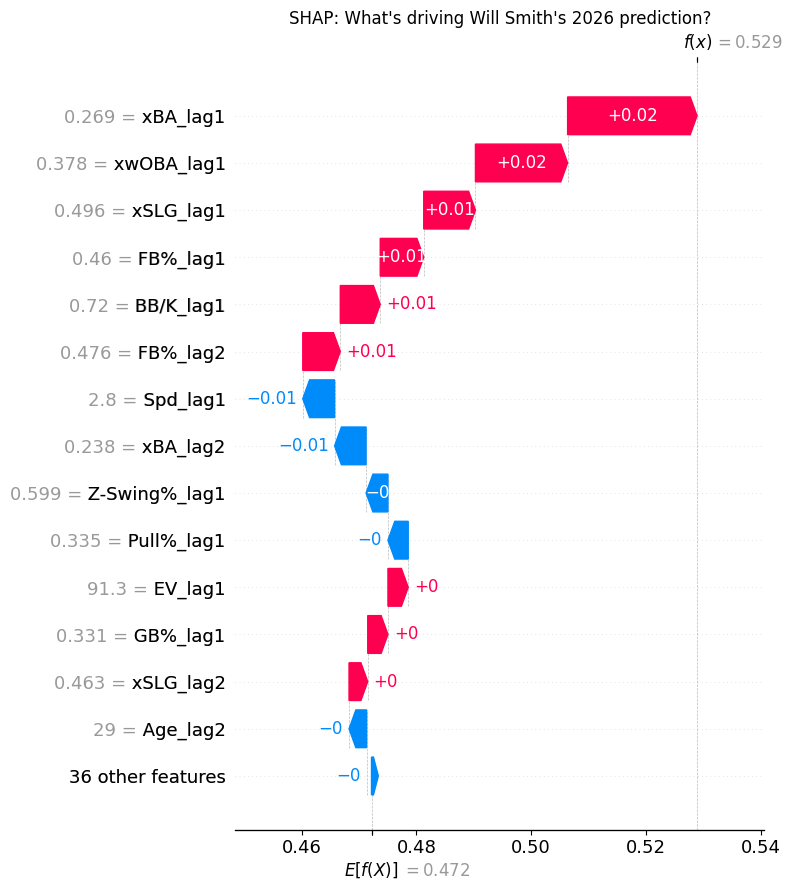

In [108]:
# Example: explain a batter's 2026 prediction
explain_batter_2026("Will Smith")

In [109]:
# Save rate predictions
os.makedirs('predictions', exist_ok=True)
pred_2026_bat.to_csv('predictions/batters_2026_rate_predictions.csv', index=False)
print("Saved to predictions/batters_2026_rate_predictions.csv")

Saved to predictions/batters_2026_rate_predictions.csv


---
## Part 2: Pitcher Predictions
---

### 2.1 Load Data & Retrain Model

In [110]:
# Load processed pitcher data
pitchers = pd.read_csv(f"{PROCESSED_DATA_DIR}/pitchers_processed.csv")
print(f"Loaded {len(pitchers)} pitcher-seasons")
print(f"Years: {pitchers['Season'].min()} - {pitchers['Season'].max()}")

# Feature columns
feature_cols_pit = [c for c in pitchers.columns if '_lag' in c]

# Also include arsenal columns if present
arsenal_cols = [c for c in pitchers.columns if c.startswith(('ff_', 'si_', 'sl_', 'ch_', 'cu_'))]
feature_cols_pit = feature_cols_pit + [c for c in arsenal_cols if c not in feature_cols_pit]

print(f"\nFeatures: {len(feature_cols_pit)}")

Loaded 4104 pitcher-seasons
Years: 2016 - 2025

Features: 119


In [111]:
# Train on ALL data for final model
train_df_pit = pitchers.copy()

X_train_pit = train_df_pit[feature_cols_pit].copy()
y_train_pit = train_df_pit['Fpoints_IP'].copy()

# Fill NaN with median
train_medians_pit = X_train_pit.median()
X_train_pit = X_train_pit.fillna(train_medians_pit)

print(f"Training set: {len(X_train_pit)} rows (all years)")
print(f"Features: {X_train_pit.shape[1]}")

Training set: 4104 rows (all years)
Features: 119


In [112]:
# Train XGBoost (best performer from evaluation)
xgb_pit = XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

print("Training pitcher model on all data...")
xgb_pit.fit(X_train_pit, y_train_pit)
print("Done!")

# Store for later use
pitcher_model = xgb_pit

Training pitcher model on all data...
Done!


### 2.2 Prepare 2026 Prediction Data

In [113]:
# Get 2025 pitcher data
pitchers_2025 = pitchers[pitchers['Season'] == 2025].copy()
print(f"Pitchers with 2025 data: {len(pitchers_2025)}")

# Get base feature names
base_features_pit = list(set([c.replace('_lag1', '').replace('_lag2', '') 
                               for c in feature_cols_pit if '_lag' in c]))
print(f"Base features: {len(base_features_pit)}")

Pitchers with 2025 data: 542
Base features: 56


In [114]:
# Create 2026 prediction dataframe
pred_2026_pit = pitchers_2025[['IDfg', 'Name', 'Team', 'Age', 'IP', 'GS', 'G', 
                                'Fpoints_IP', 'W', 'L', 'SV', 'HLD']].copy()
pred_2026_pit = pred_2026_pit.rename(columns={
    'Fpoints_IP': 'Fpoints_IP_2025', 
    'IP': 'IP_2025', 
    'Age': 'Age_2025',
    'W': 'W_2025', 'L': 'L_2025', 'SV': 'SV_2025', 'HLD': 'HLD_2025'
})
pred_2026_pit['Role'] = pred_2026_pit['GS'].apply(lambda x: 'SP' if x > 0 else 'RP')

# Build feature matrix
X_2026_pit = pd.DataFrame(index=pitchers_2025.index)

for feat in base_features_pit:
    # lag1 for 2026 = current value in 2025
    if feat in pitchers_2025.columns:
        X_2026_pit[f'{feat}_lag1'] = pitchers_2025[feat].values
    else:
        X_2026_pit[f'{feat}_lag1'] = np.nan
    
    # lag2 for 2026 = lag1 value in 2025
    lag1_col = f'{feat}_lag1'
    if lag1_col in pitchers_2025.columns:
        X_2026_pit[f'{feat}_lag2'] = pitchers_2025[lag1_col].values
    else:
        X_2026_pit[f'{feat}_lag2'] = np.nan

# Add arsenal columns (these are current-year values, not lagged)
for col in arsenal_cols:
    if col in pitchers_2025.columns:
        X_2026_pit[col] = pitchers_2025[col].values
    else:
        X_2026_pit[col] = np.nan

# Ensure column order matches training
X_2026_pit = X_2026_pit.reindex(columns=feature_cols_pit)

# Fill missing with training medians
X_2026_pit = X_2026_pit.fillna(train_medians_pit)

print(f"2026 prediction matrix: {X_2026_pit.shape}")
print(f"NaN count: {X_2026_pit.isna().sum().sum()}")

2026 prediction matrix: (542, 119)
NaN count: 0


### 2.3 Generate Rate Predictions

In [115]:
# Predict Fpoints/IP for 2026
pred_2026_pit['Predicted_Fpoints_IP'] = pitcher_model.predict(X_2026_pit)

# Sort by predicted rate
pred_2026_pit = pred_2026_pit.sort_values('Predicted_Fpoints_IP', ascending=False).reset_index(drop=True)

print("\n=== 2026 Pitcher Rate Predictions (Fpoints/IP) ===")
print(f"Pitchers: {len(pred_2026_pit)}")
print(f"\nTop 25 by predicted Fpoints/IP (all):")
display_cols = ['Name', 'Team', 'Role', 'IP_2025', 'Fpoints_IP_2025', 'Predicted_Fpoints_IP']
print(pred_2026_pit[display_cols].head(25).to_string(index=False))


=== 2026 Pitcher Rate Predictions (Fpoints/IP) ===
Pitchers: 542

Top 25 by predicted Fpoints/IP (all):
            Name  Team Role  IP_2025  Fpoints_IP_2025  Predicted_Fpoints_IP
    Mason Miller - - -   RP     61.2         3.196078              2.814065
 Aroldis Chapman   BOS   RP     61.1         3.425532              2.658652
      Edwin Diaz   NYM   RP     66.1         3.242057              2.569173
     Griffin Jax - - -   SP     66.0         2.272727              2.563469
  Devin Williams   NYY   RP     62.0         2.258065              2.515956
      Josh Hader   HOU   RP     52.2         3.134100              2.502572
    Tarik Skubal   DET   SP    195.1         2.851358              2.501202
   Shohei Ohtani   LAD   SP     47.0         2.638298              2.486497
Jeremiah Estrada   SDP   RP     73.0         2.547945              2.478809
 Garrett Crochet   BOS   SP    205.1         2.639200              2.478114
     Cole Ragans   KCR   SP     61.2         2.362745      

In [116]:
# Show SP and RP separately
print("\n=== Top 20 Starting Pitchers ===")
sp_preds = pred_2026_pit[pred_2026_pit['Role'] == 'SP']
print(sp_preds[display_cols].head(20).to_string(index=False))

print("\n=== Top 20 Relief Pitchers ===")
rp_preds = pred_2026_pit[pred_2026_pit['Role'] == 'RP']
print(rp_preds[display_cols].head(20).to_string(index=False))


=== Top 20 Starting Pitchers ===
            Name  Team Role  IP_2025  Fpoints_IP_2025  Predicted_Fpoints_IP
     Griffin Jax - - -   SP     66.0         2.272727              2.563469
    Tarik Skubal   DET   SP    195.1         2.851358              2.501202
   Shohei Ohtani   LAD   SP     47.0         2.638298              2.486497
 Garrett Crochet   BOS   SP    205.1         2.639200              2.478114
     Cole Ragans   KCR   SP     61.2         2.362745              2.473588
   Hunter Greene   CIN   SP    107.2         2.673507              2.404818
    Zack Wheeler   PHI   SP    149.2         2.765416              2.383266
    Kyle Bradish   BAL   SP     32.0         2.875000              2.370201
    Jacob deGrom   TEX   SP    172.2         2.488966              2.319488
      Chris Sale   ATL   SP    125.2         2.672524              2.268991
     Dylan Cease   SDP   SP    168.0         1.940476              2.253393
   Logan Gilbert   SEA   SP    131.0         2.526718 

### 2.4 SHAP Explainability for 2026 Pitcher Predictions

In [117]:
# Create SHAP explainer for pitcher model
# Note: Using LightGBM for SHAP since XGBoost has compatibility issues with some SHAP versions
# Train a LightGBM model for SHAP explanations
lgb_pit_shap = LGBMRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)
lgb_pit_shap.fit(X_train_pit, y_train_pit)
pitcher_explainer = shap.TreeExplainer(lgb_pit_shap)

def explain_pitcher_2026(player_name):
    """
    Show SHAP waterfall plot explaining a pitcher's 2026 prediction.
    
    Args:
        player_name: Player name (partial match supported)
    """
    # Find player in 2026 predictions
    mask = pred_2026_pit['Name'].str.contains(player_name, case=False)
    player_df = pred_2026_pit[mask]
    
    if len(player_df) == 0:
        print(f"Player '{player_name}' not found in 2026 predictions")
        similar = pred_2026_pit[pred_2026_pit['Name'].str.contains(player_name[:3], case=False)]['Name'].head(5)
        if len(similar) > 0:
            print(f"Similar names: {similar.tolist()}")
        return
    
    if len(player_df) > 1:
        print(f"Multiple matches: {player_df['Name'].tolist()}")
        player_df = player_df.iloc[[0]]
    
    player_row = player_df.iloc[0]
    
    # Get the feature row for this player from X_2026_pit
    orig_idx = pitchers_2025[pitchers_2025['Name'] == player_row['Name']].index[0]
    X_player = X_2026_pit.loc[[orig_idx]]
    
    # Get prediction (use the LightGBM model for consistency with SHAP)
    pred = lgb_pit_shap.predict(X_player)[0]
    
    role = player_row['Role']
    
    print(f"\n=== 2026 Prediction: {player_row['Name']} ({role}) ===")
    print(f"Team: {player_row['Team']}")
    print(f"2025 Stats: {player_row['IP_2025']:.1f} IP, {player_row['Fpoints_IP_2025']:.3f} Fpoints/IP")
    print(f"\nPredicted 2026 Fpoints/IP: {pred:.3f}")
    
    # Calculate SHAP values
    player_shap = pitcher_explainer(X_player)
    player_shap.feature_names = feature_cols_pit
    player_shap.data = X_player.values
    
    # Plot
    plt.figure(figsize=(10, 8))
    shap.plots.waterfall(player_shap[0], max_display=15, show=False)
    plt.title(f"SHAP: What's driving {player_row['Name']}'s 2026 prediction?")
    plt.tight_layout()
    plt.show()

print("Pitcher SHAP explainer ready - use explain_pitcher_2026('Player Name')")

Pitcher SHAP explainer ready - use explain_pitcher_2026('Player Name')



=== 2026 Prediction: Chase Burns (SP) ===
Team: CIN
2025 Stats: 43.1 IP, 2.211 Fpoints/IP

Predicted 2026 Fpoints/IP: 2.123


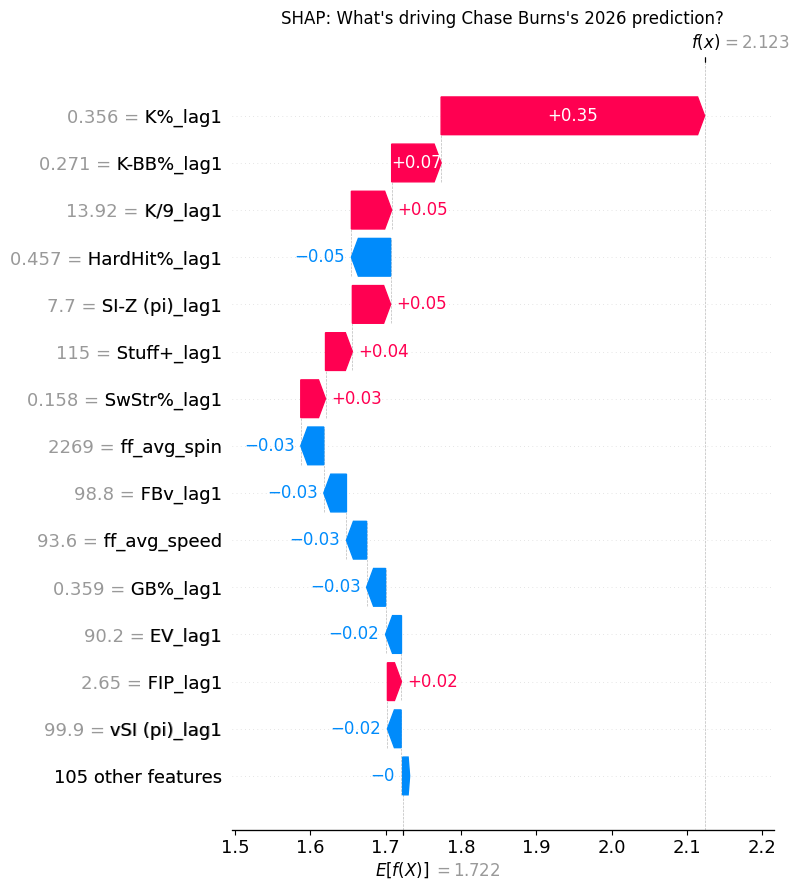

In [118]:
# Example: explain a pitcher's 2026 prediction
explain_pitcher_2026("Chase Burns")

In [119]:
# Save rate predictions
pred_2026_pit.to_csv('predictions/pitchers_2026_rate_predictions.csv', index=False)
print("Saved to predictions/pitchers_2026_rate_predictions.csv")

Saved to predictions/pitchers_2026_rate_predictions.csv


---
## Part 3: Apply External Projections

To convert rate predictions to total fantasy points, we need:
- **Batters**: PA projections
- **Pitchers**: IP, W, L, SV, HLD projections

### Projection Files Used:
- `data/projections/batx_hitters_2026.csv` - BatX batter projections (PA)
- `data/projections/oopsy_pitcher_2026.csv` - OOPSY pitcher projections (IP, W, L, SV, HLD)

Both files use `PlayerId` which maps to FanGraphs `IDfg`.

---

In [120]:
# Create projections directory
os.makedirs('data/projections', exist_ok=True)

# Check if projections exist
proj_files = os.listdir('data/projections') if os.path.exists('data/projections') else []
print("Available projection files:")
for f in proj_files:
    print(f"  - {f}")
    
if not proj_files:
    print("  (none found - download from FanGraphs)")

Available projection files:
  - oopsy_pitcher_2026.csv
  - batx_hitters_2026.csv


### 3.1 Load & Apply Batter Projections

In [121]:
# Load batter projections
BATTER_PROJ_FILE = 'data/projections/batx_hitters_2026.csv'

if os.path.exists(BATTER_PROJ_FILE):
    batter_proj = pd.read_csv(BATTER_PROJ_FILE)
    print(f"Loaded batter projections: {len(batter_proj)} players")
    print(f"Columns: {batter_proj.columns.tolist()}")
else:
    print(f"File not found: {BATTER_PROJ_FILE}")
    print("Using 2025 PA as fallback projection")
    batter_proj = None

Loaded batter projections: 667 players
Columns: ['Name', 'Team', 'G', 'PA', 'AB', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'AVG', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', 'wOBA', 'OPS', 'ISO', 'Spd', 'BABIP', 'UBR', 'wSB', 'wRC', 'wRAA', 'wRC+', 'BsR', 'Fld', 'Off', 'Def', 'WAR', 'ADP', 'InterSD', 'InterSK', 'IntraSD', 'Vol', 'Skew', 'Dim', 'FPTS', 'FPTS/G', 'SPTS', 'SPTS/G', 'P10', 'P20', 'P30', 'P40', 'P50', 'P60', 'P70', 'P80', 'P90', 'TT10', 'TT20', 'TT30', 'TT40', 'TT50', 'TT60', 'TT70', 'TT80', 'TT90', 'NameASCII', 'PlayerId', 'MLBAMID']


In [122]:
# Merge projections with predictions
if batter_proj is not None:
    # BatX uses 'PlayerId' which maps to IDfg
    id_col = 'PlayerId'
    
    # Get PA and updated Team from BatX projections
    proj_subset = batter_proj[[id_col, 'PA', 'Team', 'Name']].copy()
    proj_subset.columns = ['IDfg', 'Projected_PA', 'Proj_Team', 'Proj_Name']
    
    # Convert to numeric, coercing non-numeric IDs (like 'sa3063134' for minor leaguers) to NaN
    proj_subset['IDfg'] = pd.to_numeric(proj_subset['IDfg'], errors='coerce')
    
    # Drop rows with non-numeric IDs
    proj_subset = proj_subset.dropna(subset=['IDfg'])
    proj_subset['IDfg'] = proj_subset['IDfg'].astype(int)
    
    print(f"BatX projections with valid IDs: {len(proj_subset)}")
    
    pred_2026_bat = pred_2026_bat.merge(
        proj_subset[['IDfg', 'Projected_PA', 'Proj_Team']], 
        on='IDfg', how='left'
    )
    
    # Check how many matched
    matched = pred_2026_bat['Projected_PA'].notna().sum()
    print(f"Matched {matched} of {len(pred_2026_bat)} players with BatX projections")
    
    # Fill missing PA with 2025 PA
    pred_2026_bat['Projected_PA'] = pred_2026_bat['Projected_PA'].fillna(pred_2026_bat['PA_2025'])
    
    # Update Team with projected team where available (keep old team for fallback)
    pred_2026_bat['Team_2025'] = pred_2026_bat['Team']  # Backup old team
    pred_2026_bat['Team'] = pred_2026_bat['Proj_Team'].fillna(pred_2026_bat['Team'])
    pred_2026_bat = pred_2026_bat.drop('Proj_Team', axis=1)
    
    # Show team changes
    team_changed = pred_2026_bat[pred_2026_bat['Team'] != pred_2026_bat['Team_2025']]
    if len(team_changed) > 0:
        print(f"\nTeam changes (BatX vs 2025): {len(team_changed)}")
        print(team_changed[['Name', 'Team_2025', 'Team']].head(10).to_string(index=False))
else:
    # Use 2025 PA as projection
    pred_2026_bat['Projected_PA'] = pred_2026_bat['PA_2025']
    pred_2026_bat['Team_2025'] = pred_2026_bat['Team']

# Calculate total projected fantasy points
pred_2026_bat['Projected_Fpoints'] = pred_2026_bat['Predicted_Fpoints_PA'] * pred_2026_bat['Projected_PA']

# Sort by total
pred_2026_bat = pred_2026_bat.sort_values('Projected_Fpoints', ascending=False).reset_index(drop=True)
pred_2026_bat['Rank'] = range(1, len(pred_2026_bat) + 1)

print("\n=== 2026 Batter Total Projections ===")
display_cols = ['Rank', 'Name', 'Team', 'Projected_PA', 'Predicted_Fpoints_PA', 'Projected_Fpoints']
print(pred_2026_bat[display_cols].head(30).to_string(index=False))

BatX projections with valid IDs: 598
Matched 446 of 461 players with BatX projections

Team changes (BatX vs 2025): 112
           Name Team_2025 Team
    Kyle Tucker       CHC  LAD
    Josh Naylor     - - -  SEA
Brendan Donovan       STL  SEA
   Alex Bregman       BOS  CHC
  Carlos Correa     - - -  HOU
    Pete Alonso       NYM  BAL
    Luis Arraez       SDP  SFG
    Bo Bichette       TOR  NYM
   Caleb Durbin       MIL  BOS
    Jeff McNeil       NYM  ATH

=== 2026 Batter Total Projections ===
 Rank                  Name Team  Projected_PA  Predicted_Fpoints_PA  Projected_Fpoints
    1             Juan Soto  NYM       674.850              0.769011         518.967040
    2           Aaron Judge  NYY       637.851              0.776523         495.305922
    3         Shohei Ohtani  LAD       659.709              0.713625         470.785143
    4          Jose Ramirez  CLE       649.533              0.711536         462.166119
    5        Bobby Witt Jr.  KCR       659.965              

### 3.2 Load & Apply Pitcher Projections

In [123]:
# Load pitcher projections
PITCHER_PROJ_FILE = 'data/projections/oopsy_pitcher_2026.csv'

if os.path.exists(PITCHER_PROJ_FILE):
    pitcher_proj = pd.read_csv(PITCHER_PROJ_FILE)
    print(f"Loaded pitcher projections: {len(pitcher_proj)} players")
    print(f"Columns: {pitcher_proj.columns.tolist()}")
else:
    print(f"File not found: {PITCHER_PROJ_FILE}")
    print("Using 2025 stats as fallback projection")
    pitcher_proj = None

Loaded pitcher projections: 4333 players
Columns: ['Name', 'Team', 'W', 'L', 'QS', 'ERA', 'G', 'GS', 'SV', 'HLD', 'BS', 'IP', 'TBF', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'SO', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K%', 'BB%', 'K-BB%', 'AVG', 'WHIP', 'BABIP', 'LOB%', 'GB%', 'HR/FB', 'FIP', 'WAR', 'RA9-WAR', 'ADP', 'InterSD', 'InterSK', 'IntraSD', 'Vol', 'Skew', 'Dim', 'FPTS', 'FPTS/IP', 'SPTS', 'SPTS/IP', 'P10', 'P20', 'P30', 'P40', 'P50', 'P60', 'P70', 'P80', 'P90', 'TT10', 'TT20', 'TT30', 'TT40', 'TT50', 'TT60', 'TT70', 'TT80', 'TT90', 'NameASCII', 'PlayerId', 'MLBAMID']


In [124]:
# Merge projections with predictions
if pitcher_proj is not None:
    # OOPSY uses 'PlayerId' which maps to IDfg
    id_col = 'PlayerId'
    
    # Required columns from OOPSY (including Team for updates)
    proj_cols = ['IP', 'W', 'L', 'SV', 'HLD', 'Team']
    
    proj_subset = pitcher_proj[[id_col] + proj_cols].copy()
    proj_subset = proj_subset.rename(columns={id_col: 'IDfg', 'Team': 'Proj_Team'})
    proj_subset.columns = ['IDfg'] + [f'Proj_{c}' for c in proj_cols[:-1]] + ['Proj_Team']
    
    # Convert to numeric, coercing non-numeric IDs to NaN
    proj_subset['IDfg'] = pd.to_numeric(proj_subset['IDfg'], errors='coerce')
    
    # Drop rows with non-numeric IDs
    proj_subset = proj_subset.dropna(subset=['IDfg'])
    proj_subset['IDfg'] = proj_subset['IDfg'].astype(int)
    
    print(f"OOPSY projections with valid IDs: {len(proj_subset)}")
    
    pred_2026_pit = pred_2026_pit.merge(proj_subset, on='IDfg', how='left')
    
    # Check how many matched
    matched = pred_2026_pit['Proj_IP'].notna().sum()
    print(f"Matched {matched} of {len(pred_2026_pit)} players with OOPSY projections")
    
    # Fill missing with 2025 values
    pred_2026_pit['Proj_IP'] = pred_2026_pit['Proj_IP'].fillna(pred_2026_pit['IP_2025'])
    pred_2026_pit['Proj_W'] = pred_2026_pit['Proj_W'].fillna(pred_2026_pit['W_2025'])
    pred_2026_pit['Proj_L'] = pred_2026_pit['Proj_L'].fillna(pred_2026_pit['L_2025'])
    pred_2026_pit['Proj_SV'] = pred_2026_pit['Proj_SV'].fillna(pred_2026_pit['SV_2025'])
    pred_2026_pit['Proj_HLD'] = pred_2026_pit['Proj_HLD'].fillna(pred_2026_pit['HLD_2025'])
    
    # Update Team with projected team where available
    pred_2026_pit['Team_2025'] = pred_2026_pit['Team']  # Backup old team
    pred_2026_pit['Team'] = pred_2026_pit['Proj_Team'].fillna(pred_2026_pit['Team'])
    pred_2026_pit = pred_2026_pit.drop('Proj_Team', axis=1)
    
    # Show team changes
    team_changed = pred_2026_pit[pred_2026_pit['Team'] != pred_2026_pit['Team_2025']]
    if len(team_changed) > 0:
        print(f"\nTeam changes (OOPSY vs 2025): {len(team_changed)}")
        print(team_changed[['Name', 'Team_2025', 'Team', 'Role']].head(10).to_string(index=False))
else:
    # Use 2025 stats as projection
    pred_2026_pit['Proj_IP'] = pred_2026_pit['IP_2025']
    pred_2026_pit['Proj_W'] = pred_2026_pit['W_2025']
    pred_2026_pit['Proj_L'] = pred_2026_pit['L_2025']
    pred_2026_pit['Proj_SV'] = pred_2026_pit['SV_2025']
    pred_2026_pit['Proj_HLD'] = pred_2026_pit['HLD_2025']
    pred_2026_pit['Team_2025'] = pred_2026_pit['Team']

print("Projection columns added")

OOPSY projections with valid IDs: 1184
Matched 533 of 542 players with OOPSY projections

Team changes (OOPSY vs 2025): 162
          Name Team_2025 Team Role
  Mason Miller     - - -  SDP   RP
    Edwin Diaz       NYM  LAD   RP
   Griffin Jax     - - -  TBR   SP
Devin Williams       NYY  NYM   RP
   Jhoan Duran     - - -  PHI   RP
 Brock Stewart     - - -  LAD   RP
  David Bednar     - - -  NYY   RP
  Ryan Helsley     - - -  BAL   RP
   Dylan Cease       SDP  TOR   SP
 Robert Suarez       SDP  ATL   RP
Projection columns added


In [125]:
# Calculate total projected fantasy points
# Skill-based points
pred_2026_pit['Proj_Skill_Fpoints'] = pred_2026_pit['Predicted_Fpoints_IP'] * pred_2026_pit['Proj_IP']

# Team-based points (W/L/SV/HLD)
pred_2026_pit['Proj_Team_Fpoints'] = (
    pred_2026_pit['Proj_W'] * PITCHER_SCORING_TEAM['W'] +
    pred_2026_pit['Proj_L'] * PITCHER_SCORING_TEAM['L'] +
    pred_2026_pit['Proj_SV'] * PITCHER_SCORING_TEAM['SV'] +
    pred_2026_pit['Proj_HLD'] * PITCHER_SCORING_TEAM['HLD']
)

# Total
pred_2026_pit['Projected_Fpoints'] = pred_2026_pit['Proj_Skill_Fpoints'] + pred_2026_pit['Proj_Team_Fpoints']

# Sort by total
pred_2026_pit = pred_2026_pit.sort_values('Projected_Fpoints', ascending=False).reset_index(drop=True)
pred_2026_pit['Rank'] = range(1, len(pred_2026_pit) + 1)

print("\n=== 2026 Pitcher Total Projections ===")
display_cols = ['Rank', 'Name', 'Team', 'Role', 'Proj_IP', 'Predicted_Fpoints_IP', 
                'Proj_Skill_Fpoints', 'Proj_Team_Fpoints', 'Projected_Fpoints']
print(pred_2026_pit[display_cols].head(30).to_string(index=False))


=== 2026 Pitcher Total Projections ===
 Rank               Name Team Role  Proj_IP  Predicted_Fpoints_IP  Proj_Skill_Fpoints  Proj_Team_Fpoints  Projected_Fpoints
    1       Tarik Skubal  DET   SP    205.0              2.501202          512.746334               16.0         528.746334
    2    Garrett Crochet  BOS   SP    197.0              2.478114          488.188436               12.0         500.188436
    3      Hunter Greene  CIN   SP    183.0              2.404818          440.081748                8.0         448.081748
    4        Paul Skenes  PIT   SP    198.0              2.142650          424.244678               14.0         438.244678
    5        Cole Ragans  KCR   SP    173.0              2.473588          427.930805                8.0         435.930805
    6        Dylan Cease  TOR   SP    189.0              2.253393          425.891220                6.0         431.891220
    7          Bryan Woo  SEA   SP    200.0              2.021060          404.211998       

In [126]:
# Show SP and RP rankings separately
print("\n=== Top 25 Starting Pitchers ===")
sp_final = pred_2026_pit[pred_2026_pit['Role'] == 'SP'].copy()
sp_final['SP_Rank'] = range(1, len(sp_final) + 1)
print(sp_final[['SP_Rank', 'Name', 'Team', 'Proj_IP', 'Proj_W', 'Proj_L', 'Projected_Fpoints']].head(25).to_string(index=False))

print("\n=== Top 25 Relief Pitchers ===")
rp_final = pred_2026_pit[pred_2026_pit['Role'] == 'RP'].copy()
rp_final['RP_Rank'] = range(1, len(rp_final) + 1)
print(rp_final[['RP_Rank', 'Name', 'Team', 'Proj_IP', 'Proj_SV', 'Proj_HLD', 'Projected_Fpoints']].head(25).to_string(index=False))


=== Top 25 Starting Pitchers ===
 SP_Rank               Name Team  Proj_IP  Proj_W  Proj_L  Projected_Fpoints
       1       Tarik Skubal  DET    205.0    15.0     7.0         528.746334
       2    Garrett Crochet  BOS    197.0    14.0     8.0         500.188436
       3      Hunter Greene  CIN    183.0    12.0     8.0         448.081748
       4        Paul Skenes  PIT    198.0    14.0     7.0         438.244678
       5        Cole Ragans  KCR    173.0    12.0     8.0         435.930805
       6        Dylan Cease  TOR    189.0    13.0    10.0         431.891220
       7          Bryan Woo  SEA    200.0    14.0     9.0         414.211998
       8       Jacob deGrom  TEX    174.0    11.0     8.0         409.590962
       9 Cristopher Sanchez  PHI    204.0    15.0     8.0         401.337353
      10         Chris Sale  ATL    166.0    13.0     7.0         388.652505
      11      Logan Gilbert  SEA    167.0    12.0     7.0         382.023829
      12      Jesus Luzardo  PHI    180.0 

---
## Part 4: Save Final Rankings
---

---
## Part 3.5: Add Position Data

Load position data from ESPN rankings to enhance our predictions.

In [127]:
# Load position data from ESPN (primary) and MLB Stats API (fallback)
from difflib import SequenceMatcher
import requests

# === Step 1: Load ESPN rankings for position data (primary source) ===
ESPN_FILE = 'data/espn/espn_rankings_2026.csv'
espn_positions = {}

if os.path.exists(ESPN_FILE):
    espn_data = pd.read_csv(ESPN_FILE)
    print(f"Loaded ESPN data: {len(espn_data)} players with positions")
    
    # Create position mapping from ESPN
    for _, row in espn_data.iterrows():
        if pd.notna(row['Position']) and row['Position']:
            espn_positions[row['Name'].lower().strip()] = row['Position']
    
    print(f"ESPN positions available: {len(espn_positions)}")
else:
    print(f"ESPN file not found: {ESPN_FILE}")

# === Step 2: Fetch MLB Stats API for positions (fallback for non-ESPN players) ===
print("\nFetching MLB Stats API for additional positions...")

mlb_positions = {}
try:
    url = 'https://statsapi.mlb.com/api/v1/sports/1/players?season=2025'
    resp = requests.get(url, timeout=15)
    if resp.status_code == 200:
        players = resp.json().get('people', [])
        print(f"MLB API returned {len(players)} players")
        
        for p in players:
            name = p.get('fullName', '').lower().strip()
            pos = p.get('primaryPosition', {}).get('abbreviation', '')
            if name and pos:
                # Map pitcher positions to SP/RP based on common patterns
                # Note: MLB API just says "P" for pitchers, we'll keep that for now
                mlb_positions[name] = pos
        
        print(f"MLB positions available: {len(mlb_positions)}")
except Exception as e:
    print(f"MLB API error: {e}")
    print("Will use ESPN positions only")

# === Step 3: Fuzzy matching helper ===
def fuzzy_match(name, name_dict, threshold=0.85):
    """Find best matching name from dictionary keys."""
    name_lower = name.lower().strip()
    
    # Exact match first
    if name_lower in name_dict:
        return name_dict[name_lower]
    
    # Fuzzy match
    best_match, best_score = None, 0
    for key in name_dict.keys():
        score = SequenceMatcher(None, name_lower, key).ratio()
        if score > best_score:
            best_score = score
            best_match = key
    
    if best_score >= threshold:
        return name_dict[best_match]
    return None

# === Step 4: Assign positions to batters ===
def get_position(name):
    """Get position, preferring ESPN over MLB API."""
    # Try ESPN first (has multi-position eligibility)
    pos = fuzzy_match(name, espn_positions)
    if pos:
        return pos, 'ESPN'
    
    # Fall back to MLB API
    pos = fuzzy_match(name, mlb_positions)
    if pos:
        # Convert P to Unknown for batters (they shouldn't be pitchers)
        if pos == 'P':
            return 'DH', 'MLB_API'  # Assume DH if MLB says pitcher but they're in batter list
        return pos, 'MLB_API'
    
    return 'Unknown', 'None'

# Apply to batters
positions = []
sources = []
for name in pred_2026_bat['Name']:
    pos, src = get_position(name)
    positions.append(pos)
    sources.append(src)

pred_2026_bat['Position'] = positions
pred_2026_bat['Position_Source'] = sources

# Summary
print("\nPosition assignment summary (batters):")
print(pred_2026_bat['Position_Source'].value_counts())

# Primary position for grouping
pred_2026_bat['Primary_Pos'] = pred_2026_bat['Position'].apply(
    lambda x: x.split('/')[0] if pd.notna(x) and x != 'Unknown' else 'Unknown'
)

print("\nPosition distribution:")
print(pred_2026_bat['Primary_Pos'].value_counts())

# Show sample with positions
print("\nTop batters with positions:")
print(pred_2026_bat[['Rank', 'Name', 'Team', 'Position', 'Position_Source', 'Projected_Fpoints']].head(20).to_string(index=False))

# Show players who got positions from MLB API (not ESPN)
mlb_api_players = pred_2026_bat[pred_2026_bat['Position_Source'] == 'MLB_API']
if len(mlb_api_players) > 0:
    print(f"\nPlayers with MLB API positions (not in ESPN 300): {len(mlb_api_players)}")
    print(mlb_api_players[['Name', 'Position', 'Projected_Fpoints']].head(15).to_string(index=False))

Loaded ESPN data: 300 players with positions
ESPN positions available: 300

Fetching MLB Stats API for additional positions...
MLB API returned 1471 players
MLB positions available: 1470

Position assignment summary (batters):
Position_Source
MLB_API    303
ESPN       155
None         3
Name: count, dtype: int64

Position distribution:
Primary_Pos
C          66
OF         61
2B         60
3B         56
1B         55
SS         43
LF         40
RF         39
CF         30
DH          6
Unknown     3
SP          1
RP          1
Name: count, dtype: int64

Top batters with positions:
 Rank                  Name Team Position Position_Source  Projected_Fpoints
    1             Juan Soto  NYM       OF            ESPN         518.967040
    2           Aaron Judge  NYY    OF/DH            ESPN         495.305922
    3         Shohei Ohtani  LAD    DH/SP            ESPN         470.785143
    4          Jose Ramirez  CLE    3B/DH            ESPN         462.166119
    5        Bobby Witt Jr. 

In [128]:
# Save final predictions with totals (including positions)
# Select columns for export
batter_export_cols = ['IDfg', 'Name', 'Team', 'Position', 'Projected_PA', 
                       'Predicted_Fpoints_PA', 'Projected_Fpoints', 'Rank']
pred_2026_bat[batter_export_cols].to_csv('predictions/batters_2026_final.csv', index=False)

pitcher_export_cols = ['IDfg', 'Name', 'Team', 'Role', 'Proj_IP', 'Proj_W', 'Proj_L', 'Proj_SV', 'Proj_HLD',
                        'Predicted_Fpoints_IP', 'Projected_Fpoints', 'Rank']
pred_2026_pit[pitcher_export_cols].to_csv('predictions/pitchers_2026_final.csv', index=False)

print("Saved final predictions:")
print("  - predictions/batters_2026_final.csv")
print("  - predictions/pitchers_2026_final.csv")

# Show sample of final batter output
print("\nBatter output sample:")
print(pred_2026_bat[['Rank', 'Name', 'Team', 'Position', 'Projected_Fpoints']].head(10).to_string(index=False))

Saved final predictions:
  - predictions/batters_2026_final.csv
  - predictions/pitchers_2026_final.csv

Batter output sample:
 Rank                  Name Team Position  Projected_Fpoints
    1             Juan Soto  NYM       OF         518.967040
    2           Aaron Judge  NYY    OF/DH         495.305922
    3         Shohei Ohtani  LAD    DH/SP         470.785143
    4          Jose Ramirez  CLE    3B/DH         462.166119
    5        Bobby Witt Jr.  KCR       SS         454.145205
    6 Vladimir Guerrero Jr.  TOR    1B/DH         418.279748
    7           Kyle Tucker  LAD       OF         413.257412
    8    Fernando Tatis Jr.  SDP       OF         395.381186
    9           Ketel Marte  ARI    2B/DH         395.178999
   10      Gunnar Henderson  BAL       SS         384.828459


In [129]:
# Create combined overall ranking with positions
batters_ranked = pred_2026_bat[['Name', 'Team', 'Position', 'Projected_Fpoints']].copy()
batters_ranked['Type'] = 'Batter'

pitchers_ranked = pred_2026_pit[['Name', 'Team', 'Role', 'Projected_Fpoints']].copy()
pitchers_ranked['Position'] = pitchers_ranked['Role']  # SP/RP as position
pitchers_ranked['Type'] = pitchers_ranked['Role']
pitchers_ranked = pitchers_ranked.drop('Role', axis=1)

overall = pd.concat([batters_ranked, pitchers_ranked], ignore_index=True)
overall = overall.sort_values('Projected_Fpoints', ascending=False).reset_index(drop=True)
overall['Overall_Rank'] = range(1, len(overall) + 1)

print("\n=== 2026 Overall Rankings (Top 50) ===")
print(overall[['Overall_Rank', 'Name', 'Team', 'Position', 'Type', 'Projected_Fpoints']].head(50).to_string(index=False))


=== 2026 Overall Rankings (Top 50) ===
 Overall_Rank                  Name Team Position   Type  Projected_Fpoints
            1          Tarik Skubal  DET       SP     SP         528.746334
            2             Juan Soto  NYM       OF Batter         518.967040
            3       Garrett Crochet  BOS       SP     SP         500.188436
            4           Aaron Judge  NYY    OF/DH Batter         495.305922
            5         Shohei Ohtani  LAD    DH/SP Batter         470.785143
            6          Jose Ramirez  CLE    3B/DH Batter         462.166119
            7        Bobby Witt Jr.  KCR       SS Batter         454.145205
            8         Hunter Greene  CIN       SP     SP         448.081748
            9           Paul Skenes  PIT       SP     SP         438.244678
           10           Cole Ragans  KCR       SP     SP         435.930805
           11           Dylan Cease  TOR       SP     SP         431.891220
           12 Vladimir Guerrero Jr.  TOR    1B/D

In [130]:
# Save overall rankings with positions
overall_export = overall[['Overall_Rank', 'Name', 'Team', 'Position', 'Type', 'Projected_Fpoints']]
overall_export.to_csv('predictions/overall_2026_rankings.csv', index=False)
print("Saved to predictions/overall_2026_rankings.csv")

# Summary stats
print(f"\n=== Summary ===")
print(f"Total players ranked: {len(overall)}")
print(f"  Batters: {len(overall[overall['Type'] == 'Batter'])}")
print(f"  SP: {len(overall[overall['Type'] == 'SP'])}")
print(f"  RP: {len(overall[overall['Type'] == 'RP'])}")

Saved to predictions/overall_2026_rankings.csv

=== Summary ===
Total players ranked: 1003
  Batters: 461
  SP: 328
  RP: 214


---
## Part 5: Position-Specific Rankings
---

In [131]:
# Create position-specific rankings
# Map batters to fantasy-relevant positions

def get_eligible_positions(pos_str):
    """Expand position string to list of eligible positions."""
    if pd.isna(pos_str) or pos_str == 'Unknown':
        return []
    return pos_str.split('/')

# Fantasy-relevant position groups
POSITION_GROUPS = {
    'C': ['C'],
    '1B': ['1B'],
    '2B': ['2B'],
    '3B': ['3B'],
    'SS': ['SS'],
    'OF': ['OF', 'LF', 'CF', 'RF'],
    'DH': ['DH'],
    'SP': ['SP'],
    'RP': ['RP']
}

def player_eligible_for(position, pos_list):
    """Check if player is eligible for a position."""
    eligible_positions = POSITION_GROUPS.get(position, [position])
    return any(p in eligible_positions for p in pos_list)

# Create rankings for each position
position_rankings = {}

# Batter positions
batter_positions = ['C', '1B', '2B', '3B', 'SS', 'OF', 'DH']
for pos in batter_positions:
    # Find all players eligible at this position
    eligible = pred_2026_bat[pred_2026_bat['Position'].apply(
        lambda x: player_eligible_for(pos, get_eligible_positions(x))
    )].copy()
    eligible = eligible.sort_values('Projected_Fpoints', ascending=False).reset_index(drop=True)
    eligible[f'{pos}_Rank'] = range(1, len(eligible) + 1)
    position_rankings[pos] = eligible
    
# Pitcher positions (already have SP/RP rankings)
position_rankings['SP'] = sp_final.copy()
position_rankings['RP'] = rp_final.copy()

# Show top 15 at each position
for pos in ['C', '1B', '2B', '3B', 'SS', 'OF', 'SP', 'RP']:
    print(f"\n=== Top 15 {pos} ===")
    df = position_rankings[pos]
    if pos in batter_positions:
        cols = [f'{pos}_Rank', 'Name', 'Team', 'Position', 'Projected_Fpoints']
        print(df[cols].head(15).to_string(index=False))
    else:
        rank_col = 'SP_Rank' if pos == 'SP' else 'RP_Rank'
        cols = [rank_col, 'Name', 'Team', 'Proj_IP', 'Projected_Fpoints']
        print(df[cols].head(15).to_string(index=False))


=== Top 15 C ===
 C_Rank              Name Team Position  Projected_Fpoints
      1       Cal Raleigh  SEA     C/DH         342.417968
      2 William Contreras  MIL     C/DH         334.928845
      3          Ben Rice  NYY  1B/C/DH         320.545924
      4    Salvador Perez  KCR  C/1B/DH         313.718963
      5     Drake Baldwin  ATL        C         299.355343
      6   Adley Rutschman  BAL        C         293.035277
      7   Shea Langeliers  ATH        C         292.743341
      8    Hunter Goodman  COL     C/DH         282.253868
      9       Yainer Diaz  HOU     C/DH         277.367505
     10    Alejandro Kirk  TOR        C         276.012297
     11   Agustin Ramirez  MIA     C/DH         273.345348
     12        Will Smith  LAD        C         264.902450
     13    Gabriel Moreno  ARI        C         248.691231
     14      Ryan Jeffers  MIN        C         228.401272
     15 Francisco Alvarez  NYM        C         218.393131

=== Top 15 1B ===
 1B_Rank           

In [132]:
# Export position-specific rankings
os.makedirs('predictions/by_position', exist_ok=True)

# Export each position
for pos in ['C', '1B', '2B', '3B', 'SS', 'OF', 'DH', 'SP', 'RP']:
    df = position_rankings[pos]
    output_file = f'predictions/by_position/{pos.lower()}_2026_rankings.csv'
    
    if pos in batter_positions:
        export_cols = [f'{pos}_Rank', 'Name', 'Team', 'Position', 'Projected_PA', 
                       'Predicted_Fpoints_PA', 'Projected_Fpoints']
        export_df = df[export_cols].copy()
        export_df.columns = ['Rank', 'Name', 'Team', 'Position', 'Projected_PA', 
                             'Fpoints_PA', 'Projected_Fpoints']
    else:
        rank_col = 'SP_Rank' if pos == 'SP' else 'RP_Rank'
        export_cols = [rank_col, 'Name', 'Team', 'Proj_IP', 'Predicted_Fpoints_IP', 'Projected_Fpoints']
        export_df = df[export_cols].copy()
        export_df.columns = ['Rank', 'Name', 'Team', 'Proj_IP', 'Fpoints_IP', 'Projected_Fpoints']
    
    export_df.to_csv(output_file, index=False)

print("Saved position-specific rankings:")
for pos in ['C', '1B', '2B', '3B', 'SS', 'OF', 'DH', 'SP', 'RP']:
    df = position_rankings[pos]
    print(f"  - predictions/by_position/{pos.lower()}_2026_rankings.csv ({len(df)} players)")

Saved position-specific rankings:
  - predictions/by_position/c_2026_rankings.csv (67 players)
  - predictions/by_position/1b_2026_rankings.csv (59 players)
  - predictions/by_position/2b_2026_rankings.csv (63 players)
  - predictions/by_position/3b_2026_rankings.csv (61 players)
  - predictions/by_position/ss_2026_rankings.csv (45 players)
  - predictions/by_position/of_2026_rankings.csv (176 players)
  - predictions/by_position/dh_2026_rankings.csv (39 players)
  - predictions/by_position/sp_2026_rankings.csv (328 players)
  - predictions/by_position/rp_2026_rankings.csv (214 players)


---
## Summary

Generated predictions saved to `predictions/` folder:

| File | Description |
|------|-------------|
| `batters_2026_rate_predictions.csv` | Predicted Fpoints/PA for all batters |
| `pitchers_2026_rate_predictions.csv` | Predicted Fpoints/IP for all pitchers |
| `batters_2026_final.csv` | Batter totals with PA projections, updated teams, positions |
| `pitchers_2026_final.csv` | Pitcher totals with IP/W/L/SV/HLD projections, updated teams |
| `overall_2026_rankings.csv` | Combined rankings (batters + pitchers) with positions |

### Position-Specific Rankings (`predictions/by_position/`)
| File | Description |
|------|-------------|
| `c_2026_rankings.csv` | Catchers |
| `1b_2026_rankings.csv` | First Basemen |
| `2b_2026_rankings.csv` | Second Basemen |
| `3b_2026_rankings.csv` | Third Basemen |
| `ss_2026_rankings.csv` | Shortstops |
| `of_2026_rankings.csv` | Outfielders |
| `dh_2026_rankings.csv` | Designated Hitters |
| `sp_2026_rankings.csv` | Starting Pitchers |
| `rp_2026_rankings.csv` | Relief Pitchers |

### PAR-Adjusted Rankings (`predictions/par_adjusted/`)
| File | Description |
|------|-------------|
| `batters_2026_par.csv` | Batters ranked by Points Above Replacement |
| `pitchers_2026_par.csv` | Pitchers ranked by Points Above Replacement |
| `overall_2026_par.csv` | Combined PAR rankings with rank change from raw |

### Data Sources
- **Teams**: Updated from BatX (batters) and OOPSY (pitchers) 2026 projections
- **Positions**: From ESPN Top 300 PDF rankings (primary), MLB Stats API (fallback)
- **PA/IP Projections**: BatX and OOPSY from FanGraphs
- **PAR**: Points Above Replacement based on 12-team league roster structure

---

---
## Part 6: Positional Adjustments (PAR)

Points Above Replacement (PAR) adjusts rankings for positional scarcity.
- Elite catchers with moderate raw points get high PAR
- Replacement-level 1B/OF get low/negative PAR
- PAR = Projected Points - Replacement Level Points (at their position)
---

In [133]:
# Import positional adjustment module
import sys
sys.path.insert(0, '.')
from src.models.positional_adjustments import (
    add_positional_adjustments,
    add_pitcher_adjustments,
    calculate_replacement_levels,
    print_replacement_summary,
    get_primary_position,
    POSITION_PRIORITY,
)
from config.roster import LEAGUE_SIZE, ROSTER_SLOTS

print("Positional adjustment module loaded")
print(f"League size: {LEAGUE_SIZE} teams")
print(f"Roster slots: {ROSTER_SLOTS}")

Positional adjustment module loaded
League size: 12 teams
Roster slots: {'C': 1, '1B': 1, '2B': 1, '3B': 1, 'SS': 1, 'OF': 3, 'DH': 1, 'P': 3, 'Bench': 3}


### 6.1 Batter PAR Calculations

In [134]:
# Apply positional adjustments to batters
batters_par = add_positional_adjustments(
    pred_2026_bat,
    points_col='Projected_Fpoints',
    position_col='Position',
    league_size=LEAGUE_SIZE,
)

# Calculate replacement levels for display
replacement_levels = calculate_replacement_levels(
    batters_par,
    points_col='Projected_Fpoints',
    position_col='Primary_Position',
    league_size=LEAGUE_SIZE,
)
print_replacement_summary(replacement_levels, "Batter Replacement Levels")

# Show top players by PAR
print("\n=== Top 30 Batters by PAR ===")
par_cols = ['PAR_Rank', 'Name', 'Team', 'Position', 'PAR_Position', 'Projected_Fpoints', 'Replacement_Level', 'PAR']
print(batters_par.sort_values('PAR', ascending=False)[par_cols].head(30).to_string(index=False))


Batter Replacement Levels
  C   :   213.9 points
  SS  :   297.8 points
  2B  :   261.1 points
  3B  :   246.1 points
  1B  :   287.1 points
  OF  :   262.0 points
  DH  :   170.1 points


=== Top 30 Batters by PAR ===
 PAR_Rank             Name Team Position PAR_Position  Projected_Fpoints  Replacement_Level        PAR
        1    Shohei Ohtani  LAD    DH/SP           SP         470.785143         170.111200 470.785143
        2    Lars Nootbaar  STL       LF           LF         271.005936                NaN 271.005936
        3        Juan Soto  NYM       OF           OF         518.967040         262.000187 256.966853
        4   Jac Caglianone  KCR       RF           RF         250.062918                NaN 250.062918
        5     Gavin Sheets  SDP       LF           LF         247.530732                NaN 247.530732
        6    Mickey Moniak  COL       RF           RF         244.225234                NaN 244.225234
        7   Ramon Laureano  SDP       RF           RF      

In [135]:
# Compare raw rank vs PAR rank - who benefits most from positional adjustment?
batters_par['Rank_Change'] = batters_par['Rank'] - batters_par['PAR_Rank']

# Biggest gainers (scarce positions)
print("=== Biggest Gainers from PAR (Scarce Positions) ===")
gainers = batters_par.nlargest(15, 'Rank_Change')
print(gainers[['Name', 'Position', 'PAR_Position', 'Rank', 'PAR_Rank', 'Rank_Change', 'PAR']].to_string(index=False))

# Biggest losers (deep positions) 
print("\n=== Biggest Losers from PAR (Deep Positions) ===")
losers = batters_par.nsmallest(15, 'Rank_Change')
print(losers[['Name', 'Position', 'PAR_Position', 'Rank', 'PAR_Rank', 'Rank_Change', 'PAR']].to_string(index=False))

=== Biggest Gainers from PAR (Scarce Positions) ===
               Name Position PAR_Position  Rank  PAR_Rank  Rank_Change       PAR
        Myles Straw       CF           CF   372       125          247 71.920652
         Alan Roden       LF           LF   373       126          247 71.556662
       James Outman       CF           CF   370       124          246 73.564527
        Nick Loftin       LF           LF   375       129          246 67.963462
      Austin Slater       LF           LF   376       130          246 67.115043
     Michael Helman       CF           CF   380       135          245 64.648469
    Joshua Palacios       RF           RF   389       145          244 55.529505
          Alex Call       RF           RF   351       108          243 83.164732
Justyn-Henry Malloy       RF           RF   366       123          243 76.143022
          John Rave       RF           RF   390       147          243 55.389265
        Johan Rojas       CF           CF   404       161

### 6.2 Pitcher PAR Calculations

Pitchers have minimal positional adjustment since there's no SP/RP distinction in roster slots - all pitchers compete for the same 3 P slots per team.

In [136]:
# Apply positional adjustments to pitchers
pitchers_par = add_pitcher_adjustments(
    pred_2026_pit,
    points_col='Projected_Fpoints',
    league_size=LEAGUE_SIZE,
)

print(f"Pitcher replacement level: {pitchers_par['Replacement_Level'].iloc[0]:.1f} points")

# Show top pitchers by PAR
print("\n=== Top 30 Pitchers by PAR ===")
pit_par_cols = ['PAR_Rank', 'Name', 'Team', 'Role', 'Projected_Fpoints', 'Replacement_Level', 'PAR']
print(pitchers_par.sort_values('PAR', ascending=False)[pit_par_cols].head(30).to_string(index=False))

Pitcher replacement level: 313.3 points

=== Top 30 Pitchers by PAR ===
 PAR_Rank               Name Team Role  Projected_Fpoints  Replacement_Level        PAR
        1       Tarik Skubal  DET   SP         528.746334          313.30478 215.441554
        2    Garrett Crochet  BOS   SP         500.188436          313.30478 186.883656
        3      Hunter Greene  CIN   SP         448.081748          313.30478 134.776968
        4        Paul Skenes  PIT   SP         438.244678          313.30478 124.939898
        5        Cole Ragans  KCR   SP         435.930805          313.30478 122.626025
        6        Dylan Cease  TOR   SP         431.891220          313.30478 118.586440
        7          Bryan Woo  SEA   SP         414.211998          313.30478 100.907218
        8       Jacob deGrom  TEX   SP         409.590962          313.30478  96.286182
        9 Cristopher Sanchez  PHI   SP         401.337353          313.30478  88.032573
       10         Chris Sale  ATL   SP         3

### 6.3 Combined PAR Rankings

In [137]:
# Combine batters and pitchers for overall PAR rankings
batters_for_combine = batters_par[['Name', 'Team', 'Position', 'Projected_Fpoints', 'PAR', 'Rank']].copy()
batters_for_combine['Type'] = 'Batter'
batters_for_combine['Raw_Rank'] = batters_for_combine['Rank']

pitchers_for_combine = pitchers_par[['Name', 'Team', 'Role', 'Projected_Fpoints', 'PAR', 'Rank']].copy()
pitchers_for_combine = pitchers_for_combine.rename(columns={'Role': 'Position'})
pitchers_for_combine['Type'] = pitchers_for_combine['Position']  # SP or RP
pitchers_for_combine['Raw_Rank'] = pitchers_for_combine['Rank']

# Combine and rank by PAR
overall_par = pd.concat([batters_for_combine, pitchers_for_combine], ignore_index=True)
overall_par = overall_par.sort_values('PAR', ascending=False).reset_index(drop=True)
overall_par['Overall_PAR_Rank'] = range(1, len(overall_par) + 1)

# Calculate rank change from raw to PAR
overall_par = overall_par.sort_values('Projected_Fpoints', ascending=False).reset_index(drop=True)
overall_par['Overall_Raw_Rank'] = range(1, len(overall_par) + 1)
overall_par = overall_par.sort_values('PAR', ascending=False).reset_index(drop=True)
overall_par['Rank_Change'] = overall_par['Overall_Raw_Rank'] - overall_par['Overall_PAR_Rank']

print("=== Top 50 Overall by PAR ===")
display_cols = ['Overall_PAR_Rank', 'Name', 'Team', 'Position', 'Type', 'Projected_Fpoints', 'PAR', 'Rank_Change']
print(overall_par[display_cols].head(50).to_string(index=False))

=== Top 50 Overall by PAR ===
 Overall_PAR_Rank                Name Team Position   Type  Projected_Fpoints        PAR  Rank_Change
                1       Shohei Ohtani  LAD    DH/SP Batter         470.785143 470.785143            4
                2       Lars Nootbaar  STL       LF Batter         271.005936 271.005936          200
                3           Juan Soto  NYM       OF Batter         518.967040 256.966853           -1
                4      Jac Caglianone  KCR       RF Batter         250.062918 250.062918          247
                5        Gavin Sheets  SDP       LF Batter         247.530732 247.530732          252
                6       Mickey Moniak  COL       RF Batter         244.225234 244.225234          260
                7      Ramon Laureano  SDP       RF Batter         242.413422 242.413422          265
                8         Aaron Judge  NYY    OF/DH Batter         495.305922 233.305736           -4
                9        Nathan Lukes  TOR       RF 

In [138]:
# Show biggest movers overall
print("=== Biggest Overall Gainers from PAR ===")
top_gainers = overall_par.nlargest(20, 'Rank_Change')
print(top_gainers[['Name', 'Position', 'Type', 'Overall_Raw_Rank', 'Overall_PAR_Rank', 'Rank_Change', 'PAR']].to_string(index=False))

print("\n=== Biggest Overall Losers from PAR ===")
top_losers = overall_par.nsmallest(20, 'Rank_Change')
print(top_losers[['Name', 'Position', 'Type', 'Overall_Raw_Rank', 'Overall_PAR_Rank', 'Rank_Change', 'PAR']].to_string(index=False))

=== Biggest Overall Gainers from PAR ===
              Name Position   Type  Overall_Raw_Rank  Overall_PAR_Rank  Rank_Change       PAR
      Jose Herrera       RP Batter               958               266          692  9.263046
    Kameron Misner       CF Batter               924               233          691 24.404682
       Drew Waters       LF Batter               927               237          690 23.267311
   Taylor Trammell       LF Batter               935               245          690 18.525858
Yanquiel Fernandez       RF Batter               936               246          690 17.937138
     Weston Wilson       LF Batter               943               255          688 14.048165
 Brandon Lockridge       LF Batter               915               228          687 27.198527
    Jhonkensy Noel       RF Batter               949               262          687 12.204330
     Dylan Carlson       LF Batter               898               212          686 33.732064
   Heston Kjerstad 

### 6.4 Save PAR Rankings

In [139]:
# Save PAR-adjusted rankings
os.makedirs('predictions/par_adjusted', exist_ok=True)

# Batter PAR rankings
batter_par_export = batters_par[[
    'PAR_Rank', 'Name', 'Team', 'Position', 'PAR_Position', 
    'Projected_Fpoints', 'Replacement_Level', 'PAR', 'Rank', 'Rank_Change'
]].sort_values('PAR_Rank')
batter_par_export.to_csv('predictions/par_adjusted/batters_2026_par.csv', index=False)

# Pitcher PAR rankings
pitcher_par_export = pitchers_par[[
    'PAR_Rank', 'Name', 'Team', 'Role', 
    'Projected_Fpoints', 'Replacement_Level', 'PAR', 'Rank'
]].sort_values('PAR_Rank')
pitcher_par_export.to_csv('predictions/par_adjusted/pitchers_2026_par.csv', index=False)

# Overall PAR rankings
overall_par_export = overall_par[[
    'Overall_PAR_Rank', 'Name', 'Team', 'Position', 'Type',
    'Projected_Fpoints', 'PAR', 'Overall_Raw_Rank', 'Rank_Change'
]]
overall_par_export.to_csv('predictions/par_adjusted/overall_2026_par.csv', index=False)

print("Saved PAR-adjusted rankings:")
print(f"  - predictions/par_adjusted/batters_2026_par.csv ({len(batter_par_export)} players)")
print(f"  - predictions/par_adjusted/pitchers_2026_par.csv ({len(pitcher_par_export)} players)")
print(f"  - predictions/par_adjusted/overall_2026_par.csv ({len(overall_par_export)} players)")

Saved PAR-adjusted rankings:
  - predictions/par_adjusted/batters_2026_par.csv (461 players)
  - predictions/par_adjusted/pitchers_2026_par.csv (542 players)
  - predictions/par_adjusted/overall_2026_par.csv (1003 players)
